In [1]:
import torch
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from supporters import *

### Image

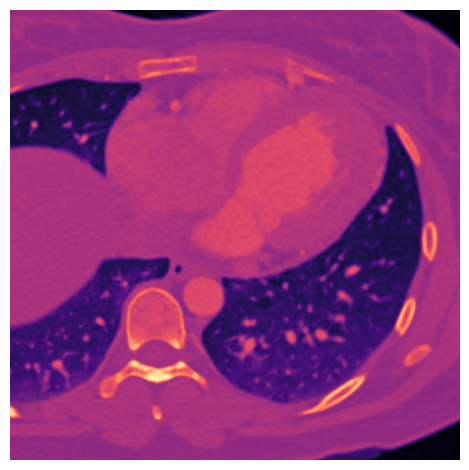

In [2]:
vol_image = sitk.GetArrayFromImage(sitk.ReadImage('data/VHSCDD_512/test_images/0001.nii.gz'))
my_image = vol_image[152]
plt.axis('off')
plt.tight_layout()
plt.imshow(my_image, cmap='magma')

In [ ]:
import torch
import torch.nn as nn
from networks.dense_feature_extraction import Dense
from networks.linear_embedding import LinearEmbedding
from networks.RotCAtt_TransUNet_plusplus import RotCAtt_TransUNet_plusplus
from networks.config import get_config

# Load the pre-trained model
model_path = 'outputs/VHSCDD_RotCAtt_TransUNet_plusplus_bs6_ps16_epo600_hw512_ly4/model.pth'
trained_model = torch.load(model_path)

# Instantiate the Dense feature extraction module
config = get_config() 
dense_feature_extraction = Dense(config)
linear_embedding = LinearEmbedding(config)

# Copy weights from the trained model to the Dense module
dense_state_dict = dense_feature_extraction.state_dict()
embedding_state_dict = linear_embedding.state_dict()

for name, param in trained_model.state_dict().items():
    if name.startswith('dense'):
        dense_state_dict[name[len("dense."):]].copy_(param)
    if name.startswith('linear_embedding'):
        embedding_state_dict[name[len("linear_embedding."):]].copy_(param)

# Set the Dense module to evaluation mode
dense_feature_extraction.eval()
linear_embedding.eval()

In [5]:
input = torch.tensor(my_image).to(torch.float32).unsqueeze(0).unsqueeze(0)
input.size()
dense_feature_extraction = Dense(config)
x1, x2, x3, x4 = dense_feature_extraction(input)

In [6]:
x1.size(), x2.size(), x3.size()

(torch.Size([1, 64, 512, 512]),
 torch.Size([1, 128, 256, 256]),
 torch.Size([1, 256, 128, 128]))

In [13]:
np_x1 = x1.squeeze(0).detach().cpu().numpy()
np_x2 = x2.squeeze(0).detach().cpu().numpy()
np_x3 = x3.squeeze(0).detach().cpu().numpy()

In [7]:
z1, z2, z3 = linear_embedding(x1, x2, x3)
z1.size(), z2.size(), z3.size()

(torch.Size([1, 1024, 64]),
 torch.Size([1, 1024, 128]),
 torch.Size([1, 1024, 256]))

In [8]:
np_z1 = z1.squeeze(0).detach().cpu().numpy()
np_z2 = z2.squeeze(0).detach().cpu().numpy()
np_z3 = z3.squeeze(0).detach().cpu().numpy()

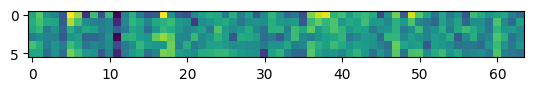

In [12]:
plt.imshow(np_z1[200:206])

In [33]:
x1_image = np_x1[0]
x2_image = np_x2[0]
x3_image = np_x3[0]

In [57]:
def show_patches(my_image, patch_size):
    patches = []

    for i in range(0, my_image.shape[0], patch_size):
        for j in range(0, my_image.shape[1], patch_size):
            patch = my_image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)

    middle = len(patches) // 2
    start = middle-3 - 10
    end = middle+3+1 - 10
    num_patches = end-start
    fig, axes = plt.subplots(1, num_patches, figsize=(15, 3))

    for i in range(num_patches):
        axes[i].imshow(patches[start + i], 'magma')
        axes[i].axis('off')

    plt.show()

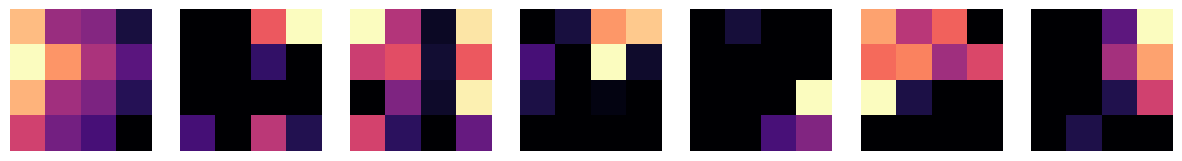

In [60]:
show_patches(x3_image, patch_size=4)

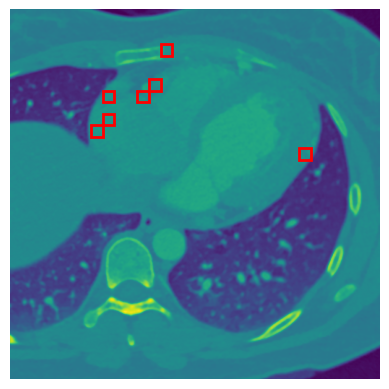

In [198]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming patch_indices is a list of patch indices you want to visualize
patch_indices = [109, 204, 235, 409, 232, 296, 327]

# Plot the original image
plt.imshow(my_image)  # Ensure cmap='gray' for grayscale images

# Loop through each patch index
for patch_index in patch_indices:
    # Calculate patch position
    patch_row = patch_index // (my_image.shape[1] // patch_size)
    patch_col = patch_index % (my_image.shape[1] // patch_size)
    
    # Calculate the coordinates of the bounding box
    bbox_x = patch_col * patch_size
    bbox_y = patch_row * patch_size
    bbox_width = patch_size
    bbox_height = patch_size

    # Draw the bounding box
    rect = patches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.axis('off')
plt.show()


### Interaction between attention weights, context matrices, rot weights after each layers in Multihead Self Attention Mechanism

In [29]:
def show(title, matrix):
    plt.title(title)
    plt.imshow(matrix)
    plt.colorbar()

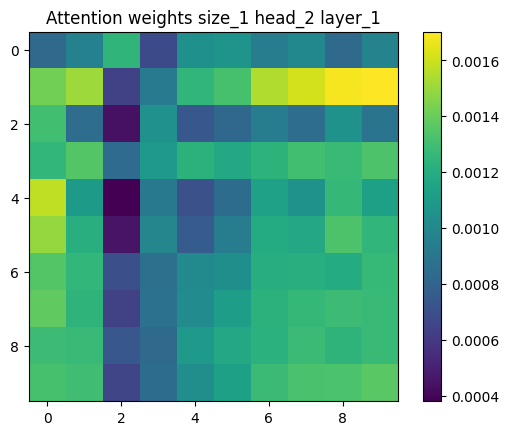

In [184]:
a_size1_head2 = sitk.GetArrayFromImage(sitk.ReadImage('outputs/RotCAtt_TransUNet_plusplus/VHSCDD_RotCAtt_TransUNet_plusplus_bs5_ps16_epo600_hw512_layer3/test/1/a_size_1_head_2.nii.gz'))
show(
    'Attention weights size_1 head_2 layer_1',
    a_size1_head2[0][200:210, 200:210]
)

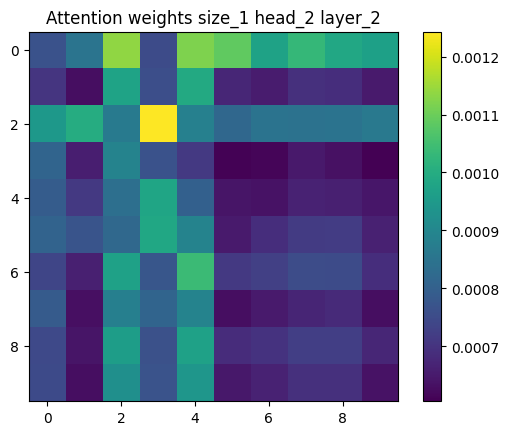

In [186]:
show(
    'Attention weights size_1 head_2 layer_2',
    a_size1_head2[1][200:210, 200:210]
)

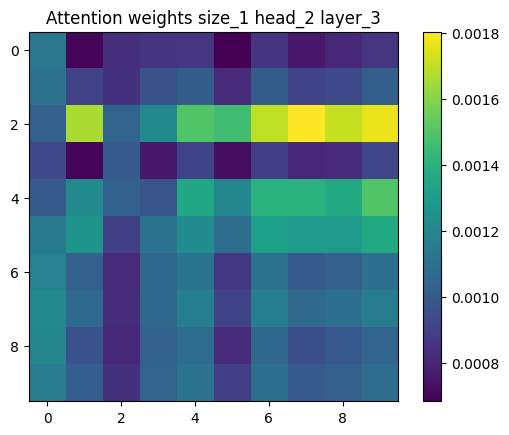

In [187]:
show(
    'Attention weights size_1 head_2 layer_3',
    a_size1_head2[2][200:210, 200:210]
)

In [196]:
a_size1_head2_layer2 = a_size1_head2[2]
indices = np.where(a_size1_head2_layer2 >= 0.0018)
indices[0][500:600]

array([76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77,
       77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
       77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78,
       78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
       79, 79, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81,
       81, 81, 81, 81, 81, 82, 82, 82, 83, 83, 83, 84, 84, 85, 85],
      dtype=int64)

In [197]:
row_indices = indices[0]
col_indices = indices[1]
filtered_indices = col_indices[row_indices == 82]
filtered_indices

array([232, 296, 327], dtype=int64)

In [17]:
n_heads = 4
def _decompose(x):
    x = torch.tensor(x)
    new_shape = x.size()[:-1] + (n_heads, x.shape[2] // n_heads)
    x = x.view(*new_shape)
    x = x.permute(0, 2, 1, 3)
    return x.detach().cpu().numpy()

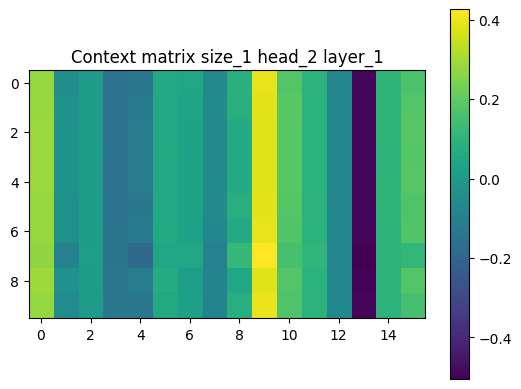

In [212]:
C_size1 = sitk.GetArrayFromImage(sitk.ReadImage('outputs/RotCAtt_TransUNet_plusplus/VHSCDD_RotCAtt_TransUNet_plusplus_bs5_ps16_epo600_hw512_layer3/test/1/c_size_1.nii.gz'))
de_C_size1 = _decompose(C_size1)

show(
    'Context matrix size_1 head_1 layer_1',
    de_C_size1[0][0][:10]
)

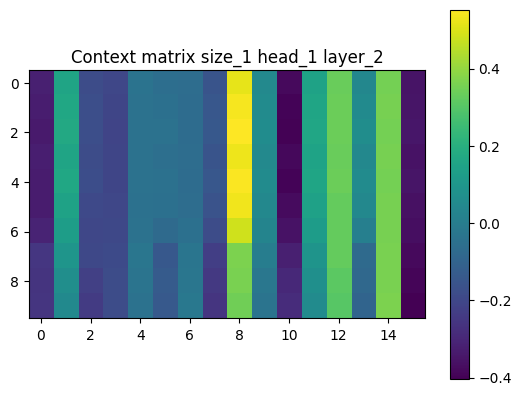

In [213]:
show(
    'Context matrix size_1 head_1 layer_2',
    de_C_size1[1][0][:10]
)

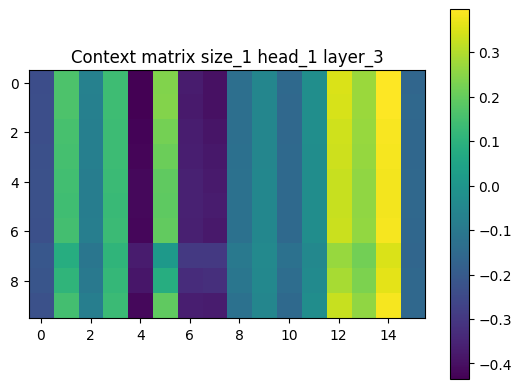

In [214]:
show(
    'Context matrix size_1 head_1 layer_3',
    de_C_size1[2][0][:10]
)

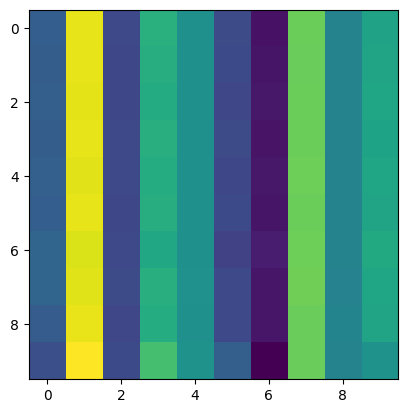

In [217]:
plt.imshow(C_size1[2][20:30, 20:30])

In [206]:
path = 'outputs/RotCAtt_TransUNet_plusplus/VHSCDD_RotCAtt_TransUNet_plusplus_bs5_ps16_epo600_hw512_layer3/test/1/r_size_1.nii.gz'
r_size1 = sitk.GetArrayFromImage(sitk.ReadImage(path))
r_size1.shape

(1, 1, 64)

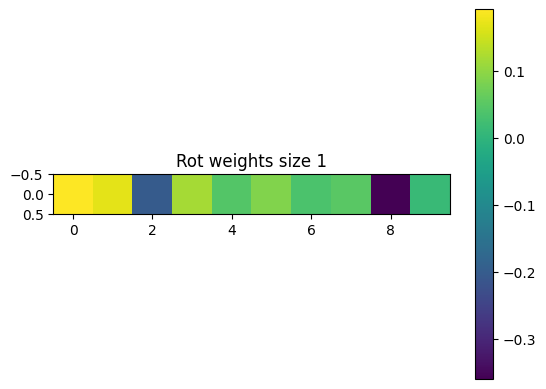

In [211]:
show(
    'Rot weights size 1',
    r_size1[0][:, 20:30]
)

In [218]:
C_size1[2].shape

(1024, 64)

In [219]:
f1 = r_size1[0] + C_size1[2]
f1.shape

(1024, 64)

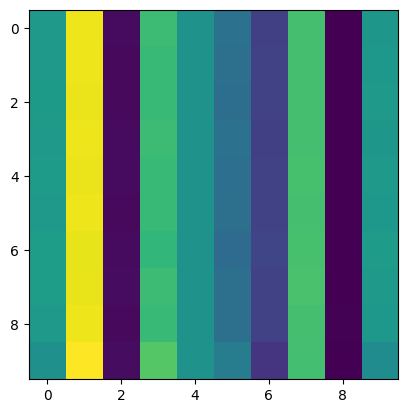

In [220]:
plt.imshow(f1[20:30, 20:30])